## Data Visualization

In [3]:
# Dependencies and packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import datetime as dt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import plotly.figure_factory as ff
from matplotlib.collections import PatchCollection

In [4]:
# Read the shared mobility data csv
csvpath = os.path.join("/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/merged_sharedmobility.csv")
df = pd.read_csv(csvpath, index_col=0, low_memory=False)

## What days of the week?

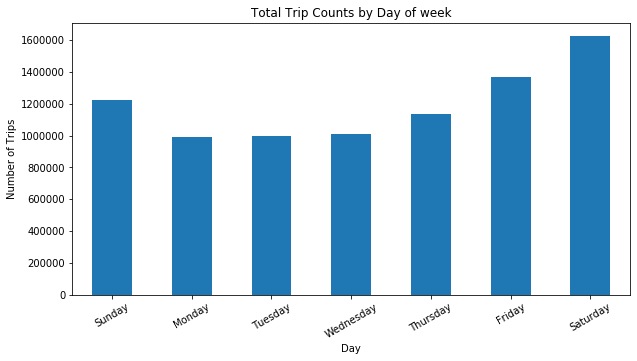

In [4]:
# Count trips per day and sort by day:
daily_total = pd.DataFrame(df['Day Of Week'].value_counts().sort_index())

# Map day of week with actual names:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_total['Day'] = days

# Plot glyph: 
daily_total.plot(kind='bar', x='Day', y='Day Of Week', title='Total Trip Counts by Day of week', figsize = (10,5), rot= 30, legend=False)
plt.ylabel("Number of Trips")
plt.savefig("Plots/trips_per_week.png")
plt.show()

## Which hours of the day are popular?

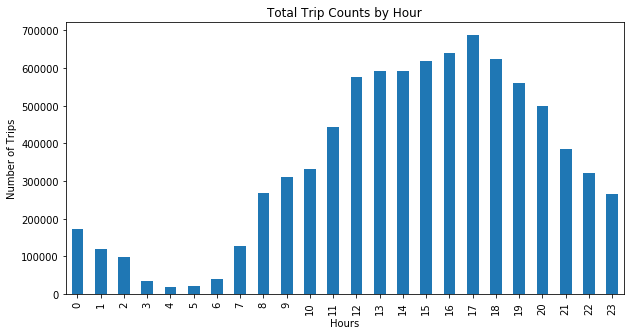

In [75]:
# Count trips per hour and sort by hour:
hourly_total = pd.DataFrame(df['Hour'].value_counts().sort_index())

hourly_total.reset_index().plot(kind='bar', 
                                x='index', 
                                y='Hour', 
                                title='Total Trip Counts by Hour', 
                                figsize = (10,5), legend=False)
plt.xlabel('Hours')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_hour.png")
plt.show()
#now shows correct plot with sorted xticks

## Are some months more popular than others?

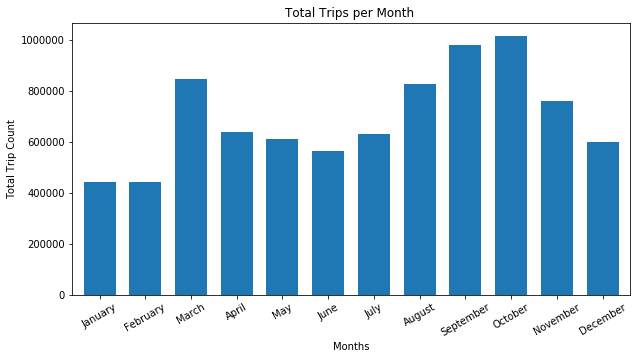

In [145]:
monthly_total = pd.DataFrame(df['Month'].value_counts()).sort_index()
import calendar
mn=[calendar.month_name[int(x)] for x in monthly_total.index.values.tolist()]

monthly_chart = monthly_total.plot.bar(title = "Total Trips per Month ",width = 0.7,figsize = (10,5),rot = 30, legend = False)
monthly_chart.set_xticklabels(mn)
monthly_chart.set_xlabel("Months")
monthly_chart.set_ylabel("Total Trip Count")
plt.savefig("Plots/trips_per_month1.png")
plt.show()
#now shows correct plot with sorted months

## Number of Scooter vs Bicycle Rides?

In [ ]:
vehicle_type = df[["Vehicle Type", "Month", "Trip Distance"]].groupby(["Vehicle Type","Month"]).sum()
vehicle_type.reset_index(inplace=True)
vehicle_type

In [ ]:
vehicle_df = vehicle_type.pivot(index="Vehicle Type", columns="Month", values="Trip Distance")
vehicle_df

Text(0, 0.5, 'Number of Trips')

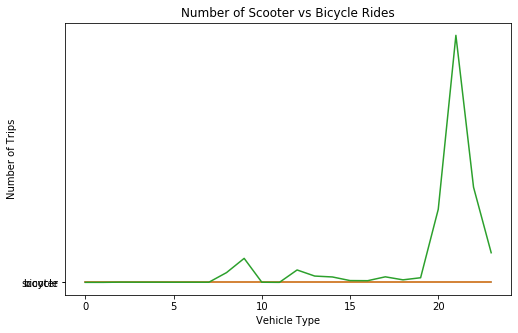

In [173]:
fig, ax = plt.subplots(figsize=(8,5))
#vehicle_df.unstack().plot(ax=ax)
for vehicle in vehicle_type.columns:
    vehicle_plot = plt.plot(vehicle_type.index, vehicle_type[vehicle])
#plot = ax.bar(vehicle_type.index, vehicle_type['Trip Distance'])
#plot2 = ax.bar(vehicle_type.index,vehicle_type['Trip Distance'])
plt.title('Number of Scooter vs Bicycle Rides')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Trips')
# STILL SHOWS WRONG PLOT

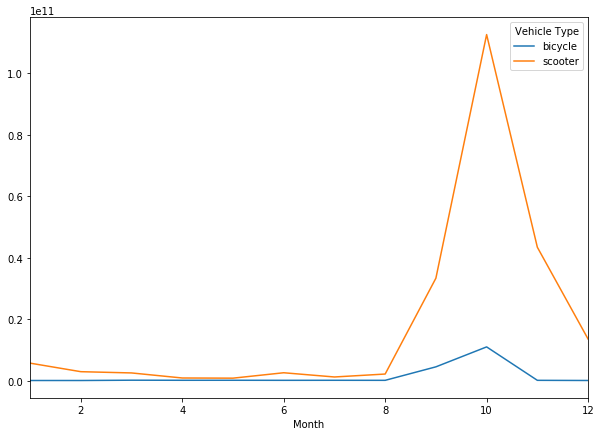

In [174]:
# Another try:
fig, ax = plt.subplots(figsize=(10,7))
df.groupby(['Month','Vehicle Type']).sum()['Trip Distance'].unstack().plot(ax=ax)
# STILL SHOWS WRONG PLOT

## Which census tracts have the most traffic?

In [61]:
# Count how many trips started in each census GEOID tract
census_trip_start = pd.DataFrame(df['Census GEOID Start'].value_counts())

In [62]:
# Count how many trips ended in each census GEOID tract
census_trip_end = pd.DataFrame(df['Census GEOID End'].value_counts())

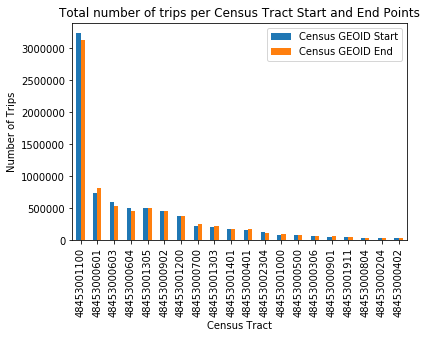

In [100]:
# Only for top 20 popular census tracts

census_traffic = census_trip_start.join(census_trip_end, how='inner')
census_traffic.head(20).plot(kind='bar')
plt.title('Total number of trips per Census Tract Start and End Points')
plt.xlabel('Census Tract')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_censustract.png")
plt.show()

## Which Zipcodes have the most traffic?

In [101]:
# Count how many trips started in each census GEOID tract
zipcode_start = pd.DataFrame(df['Zipcode Start'].value_counts())

In [102]:
# Count how many trips ended in each census tract
zipcode_end = pd.DataFrame(df['Zipcode End'].value_counts())

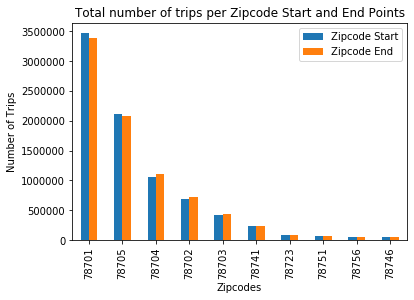

In [104]:
# Only for top 10 popular zipcodes

zipcode_traffic = zipcode_start.join(zipcode_end, how='inner')
zipcode_traffic.head(10).plot(kind='bar')
plt.title('Total number of trips per Zipcode Start and End Points')
plt.xlabel('Zipcodes')
plt.ylabel('Number of Trips')
plt.savefig("Plots/trips_per_zipcode.png")
plt.show()

## What routes are taken to start/end a trip? 

In [44]:
from shapely.geometry import Point, LineString

census = gpd.read_file('/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/census_tracts_2010_msa/census_tracts_2010_msa.shp')
streets = gpd.read_file('/Users/sheetalbongale/Scooters_In_Austin_Data_Analysis/resources/Street Centerline/geo_export_c8b73b25-2ed4-4cce-b27a-5b77fe19ba06.shp')
streets = streets.to_crs(census.crs)

In [59]:
def create_trip(x):
    start, end = x
    if start != 'OUT_OF_BOUNDS' and end != 'OUT_OF_BOUNDS':
        startpoint = census[census['TRACTCE10'] == str(int(start)).replace('48453', '')]['geometry'].iloc[0].centroid
        endpoint = census[census['TRACTCE10'] == str(int(end)).replace('48453', '')]['geometry'].iloc[0].centroid
        return LineString([startpoint, endpoint])
    else:
        return None

trip_data = df[['Census GEOID Start', 'Census GEOID End']].iloc[:10000]
trip_data['geometry'] = trip_data.apply(create_trip, axis=1)
trip_data = gpd.GeoDataFrame(trip_data, crs=census.crs)

/Users/sheetalbongale/.local/share/virtualenvs/Python-Practice-Codes-ComU94dP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

Attempting to set identical left == right == 3115650.402855188 results in singular transformations; automatically expanding.

/Users/sheetalbongale/.local/share/virtualenvs/Python-Practice-Codes-ComU94dP/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:

Attempting to set identical bottom == top == 10077822.121763384 results in singular transformations; automatically expanding.



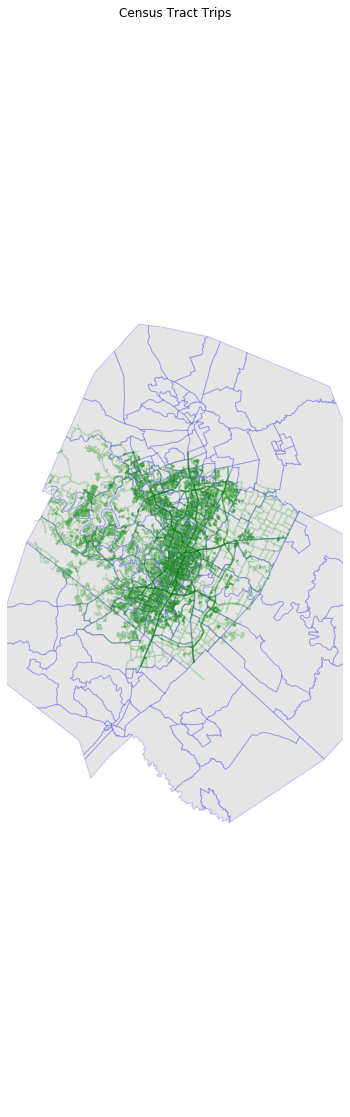

In [168]:
_, ax = plt.subplots(figsize=(20, 20))
_, _, maxx, maxy = trip_data.bounds.max()
minx, miny, _, _= trip_data.bounds.min()
census.plot(ax=ax, color='grey', edgecolor='blue', alpha=0.2)
streets.plot(ax=ax, color='green', alpha=0.2)
trip_data.plot(ax=ax, color='red', alpha=0.5)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis('off')
plt.savefig("Plots/popular_censustracts.png")
ax.set_title('Census Tract Trips');

In [105]:
census.head(5)

,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,SUM_hu_tot,SUM_hu_occ,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000101,3611.0,3130.0,39.0,276.0,90.0,9.0,67.0,2076.0,1815.0,...,38.0,151.0,79.0,103.0,303.0,354.0,77.0,805.0,1010.0,"POLYGON ((3110996.149 10094866.837, 3111365.29..."
1,000102,2552.0,2311.0,23.0,150.0,42.0,3.0,23.0,1153.0,1081.0,...,70.0,253.0,77.0,66.0,91.0,299.0,18.0,735.0,346.0,"POLYGON ((3108183.235 10097092.047, 3108282.30..."
2,000203,1546.0,1073.0,87.0,213.0,143.0,5.0,25.0,817.0,735.0,...,8.0,25.0,6.0,6.0,2.0,32.0,281.0,122.0,613.0,"POLYGON ((3117475.629 10088913.117, 3117386.12..."
3,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,1750.0,1596.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420 10081981.027, 3114644.63..."
4,000205,3394.0,2333.0,110.0,676.0,162.0,24.0,89.0,2153.0,1996.0,...,35.0,95.0,30.0,28.0,21.0,212.0,0.0,557.0,1439.0,"POLYGON ((3118490.457 10090915.154, 3118437.57..."


In [22]:
streets.head()

,geometry
0,"LINESTRING (-97.68217 30.31111, -97.68202 30.3..."
1,"LINESTRING (-97.83916 30.52056, -97.83916 30.5..."
2,"LINESTRING (-97.89384 30.37534, -97.89434 30.3..."
3,"LINESTRING (-97.76743 30.13483, -97.76796 30.1..."
4,"LINESTRING (-97.84643 30.56331, -97.84806 30.5..."


## Second try

In [42]:
census_geo_453 = census[census.COUNTYFP10=='453']
census_geo_453 = census_geo_453.set_index("GEOID10")['geometry'].to_crs(epsg=2277)
census_geo_453.head()

/Users/sheetalbongale/.local/share/virtualenvs/Python-Practice-Codes-ComU94dP/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.



GEOID10
48453001857    POLYGON ((3141480.460 10139771.862, 3141464.84...
48453001862    POLYGON ((3148523.908 10135542.678, 3148459.11...
48453001855    POLYGON ((3154154.277 10152506.666, 3154220.81...
48453001859    POLYGON ((3181994.253 10120283.169, 3181965.48...
48453001858    POLYGON ((3153491.768 10132996.089, 3153595.51...
Name: geometry, dtype: geometry

In [39]:
tract_count = df['Census GEOID Start'].value_counts()
tract_count

48453001100    3236435
48453000601     748545
48453000603     601132
48453000604     514316
48453001305     510164
                ...   
48491020509          1
48491020323          1
48021950100          1
48491020603          1
48491021502          1
Name: Census GEOID Start, Length: 246, dtype: int64

Text(0.5, 1, 'Popular rides Census Tract')

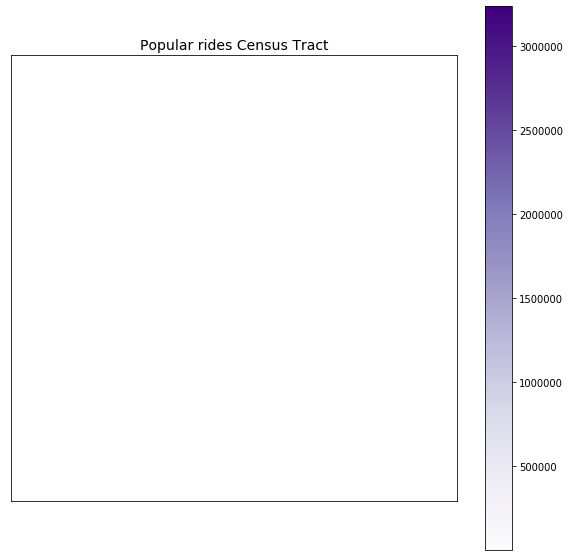

In [43]:
census_gdf = gpd.GeoDataFrame(geometry = census_geo_453, data = tract_count)
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
census_gdf.plot(column= 'Census GEOID Start', ax = ax, cmap='Purples', legend=True)
plt.title('Popular rides Census Tract', size = 14)